<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E4-SpamClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3
## Spam Classification
### Context
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Content
The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link](http://www.grumbletext.co.uk/).
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link](http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/).
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf).
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link](http://www.esp.uem.es/jmgomez/smsspamcorpus/). This corpus has been used in the following academic researches:

Acknowledgements
The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.

We offer a comprehensive study of this corpus in the following paper. This work presents a number of statistics, studies and baseline results for several machine learning methods.

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

In [1]:
!pip install wget

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve

import gensim
from gensim.models import Word2Vec
import warnings

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# nltk.download()

In [4]:
# try :
#     from google.colab import files
#     !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
#     !unzip smsspamcollection.zip
#     df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
# except ModuleNotFoundError :
#     url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
#     path = os.getcwd()+'\Data'
#     wget.download(url,path)
#     temp=path+'\smsspamcollection.zip'
#     file = ZipFile(temp)
#     file.extractall(path)
#     file.close()
#     df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

In [5]:
df = pd.read_csv('spam', sep='\t',  header=None, names=['target', 'text'])
print(f'Dimensiones del dataset: {df.shape}')
df.head()

Dimensiones del dataset: (5169, 2)


,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
print(df["target"].value_counts(normalize=True))

target
ham     0.87367
spam    0.12633
Name: proportion, dtype: float64


In [7]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

In [8]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)

Preprocess the text data by removing stop words, converting all text to lowercase, and removing punctuation using NLTK package.


In [9]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

Train a Word2Vec model on the preprocessed training data using Gensim package.

In [10]:
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4)

Convert the preprocessed text data to a vector representation using the Word2Vec model.

In [11]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

Train a classification model such as logistic regression, random forests, or support vector machines using the vectorised training data and the sentiment labels.

In [12]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

Evaluate the performance of the classification model on the testing set with the accuracy, precision, recall and F1 score.

In [13]:
y_pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.8736299161831077
AUC: 0.5


In [14]:
from funciones_auxiliares import print_metrics
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
model0_metrics = print_metrics(y_test, y_pred, y_prob)


The results of the adjustment metrics:

      Accuracy: 0.874
      Recall: 0.500
      F1-score: 0.466
      auc: 0.705
      Phi coefficient: 0.000


# Excercise 3.1

Remove stopwords, then predict target using CountVectorizer.

use Random Forest classifier

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from funciones_auxiliares import print_metrics, comparar_tamaños_vocabularios, comparar_metricas

test_size = 0.3
random_state = 18

In [16]:
print(f'Numero de duplicados: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)

X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

Numero de duplicados: 0


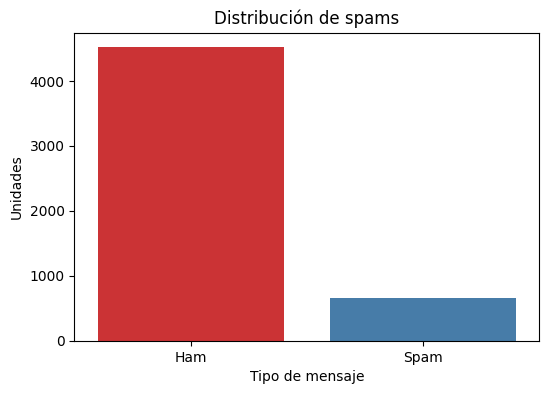

In [17]:
counts = y.value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=counts.index, y=counts.values, palette='Set1')
plt.title('Distribución de spams')
plt.xlabel('Tipo de mensaje')
plt.ylabel('Unidades')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.show()

In [18]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X = X.apply(preprocess)

In [19]:
# Creamos un CountVectorizer y transformamos los tweets
# ==============================================================================
count_vect = CountVectorizer()
X = count_vect.fit_transform(X)

In [20]:
# # Imprimir el vocabulario creado
# # ==============================================================================
# print(f"Our vocabulary: {count_vect.vocabulary_} ")

In [21]:
# Imprimir longitud de vocabulario creado
# ==============================================================================
tamaño_diccionarito1 = len(count_vect.vocabulary_)
print(f'Vocabulary size: {tamaño_diccionarito1}')

Vocabulary size: 9430


In [22]:
# Verificar tamaños
# ==============================================================================
print(f'Matrix size X: total tweets: {X.shape[0]}, Vocabulary size: {X.shape[1]}, airline_sentiment: {y.shape[0]}')

Matrix size X: total tweets: 5169, Vocabulary size: 9430, airline_sentiment: 5169


In [23]:
# Guardamos un CSV con el diccionario creado
# ==============================================================================
diccionarito = count_vect.vocabulary_
df_diccionarito = pd.DataFrame.from_dict(diccionarito, orient='index', columns=['índice'])
df_diccionarito = df_diccionarito.reset_index()
df_diccionarito.rename(columns={'index':'word'}, inplace=True)
df_diccionarito = df_diccionarito.sort_values(by=['índice'], ascending=True)
df_diccionarito.to_csv('df_diccionarito.csv', encoding = 'utf-8-sig', index = False)
df_diccionarito.head(5)

,word,índice
5643,008704050406,0
4642,0089my,1
9325,0121,2
7185,01223585236,3
5589,01223585334,4


In [24]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = df['target'], 
                                                    test_size = test_size, 
                                                    random_state = random_state)

In [25]:
# Random Forest classifier
# ==============================================================================
rf_model_1 = RandomForestClassifier(random_state=random_state)
rf_model_1.fit(X_train, y_train)

RandomForestClassifier(random_state=18)

In [26]:
y_pred = rf_model_1.predict(X_test)
y_prob = rf_model_1.predict_proba(X_test)[:, 1]
model1_metrics = print_metrics(y_test, y_pred, y_prob)


The results of the adjustment metrics:

      Accuracy: 0.966
      Recall: 0.865
      F1-score: 0.912
      auc: 0.979
      Phi coefficient: 0.838


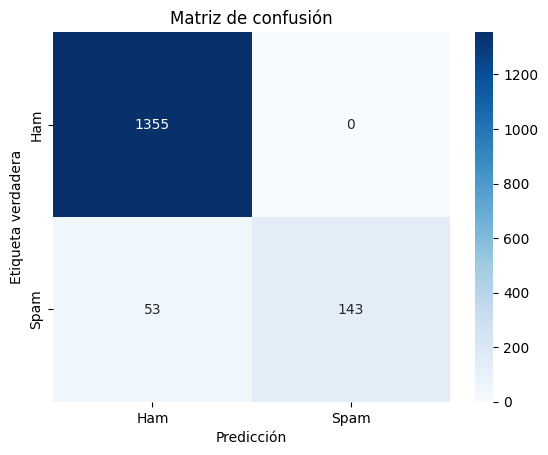

In [27]:
cm = confusion_matrix(y_test, y_pred)
class_labels = ["Ham", "Spam"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión')
plt.show()

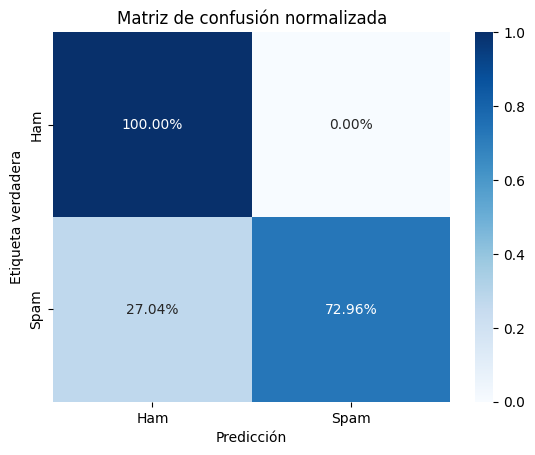

In [28]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
class_labels = ["Ham", "Spam"]
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()

# Excercise 3.2

Predict target using TdidfVectorizer.

use Random Forest classifier

In [29]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

In [31]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    text = ' '.join(text.split())
    return text

X = X.apply(preprocess)

In [32]:
# Creamos un CountVectorizer y transformamos los tweets
# ==============================================================================
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(X)

In [33]:
# # Imprimir el vocabulario creado
# # ==============================================================================
# print(f"Our vocabulary: {tfidf.vocabulary_} ")

In [34]:
# Imprimir longitud de vocabulario creado
# ==============================================================================
tamaño_diccionarito2 = len(tfidf.vocabulary_)
print(f'Vocabulary size: {tamaño_diccionarito2}')

Vocabulary size: 7490


In [35]:
# Verificar tamaños
# ==============================================================================
print(f'Matrix size X: total tweets: {X.shape[0]}, Vocabulary size: {X.shape[1]}, airline_sentiment: {y.shape[0]}')

Matrix size X: total tweets: 5169, Vocabulary size: 7490, airline_sentiment: 5169


In [36]:
# Guardamos un CSV con el diccionario creado
# ==============================================================================
diccionarito = tfidf.vocabulary_
df_diccionarito = pd.DataFrame.from_dict(diccionarito, orient='index', columns=['índice'])
df_diccionarito = df_diccionarito.reset_index()
df_diccionarito.rename(columns={'index':'word'}, inplace=True)
df_diccionarito = df_diccionarito.sort_values(by=['índice'], ascending=True)
df_diccionarito.to_csv('df_diccionarito.csv', encoding = 'utf-8-sig', index = False)
df_diccionarito.head(5)

,word,índice
6940,aa,0
3525,aah,1
3698,aaniye,2
801,aaooooright,3
1581,aathi,4


In [37]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = df['target'], 
                                                    test_size = test_size, 
                                                    random_state = random_state)

In [38]:
# Random Forest classifier
# ==============================================================================
rf_model_2 = RandomForestClassifier(random_state=random_state)
rf_model_2.fit(X_train, y_train)

RandomForestClassifier(random_state=18)

In [39]:
y_pred = rf_model_2.predict(X_test)
y_prob = rf_model_2.predict_proba(X_test)[:, 1]
model2_metrics = print_metrics(y_test, y_pred, y_prob)


The results of the adjustment metrics:

      Accuracy: 0.972
      Recall: 0.888
      F1-score: 0.929
      auc: 0.981
      Phi coefficient: 0.867


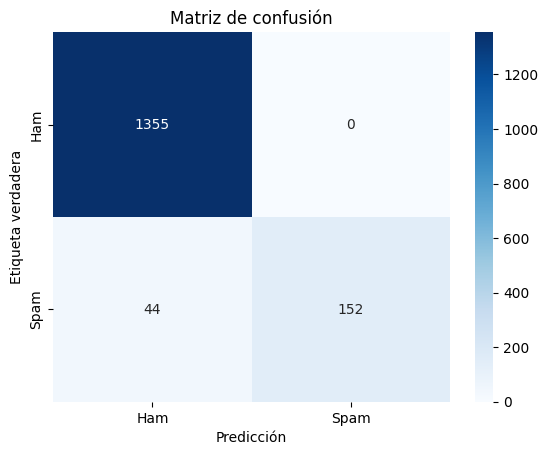

In [40]:
cm = confusion_matrix(y_test, y_pred)
class_labels = ["Ham", "Spam"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión')
plt.show()

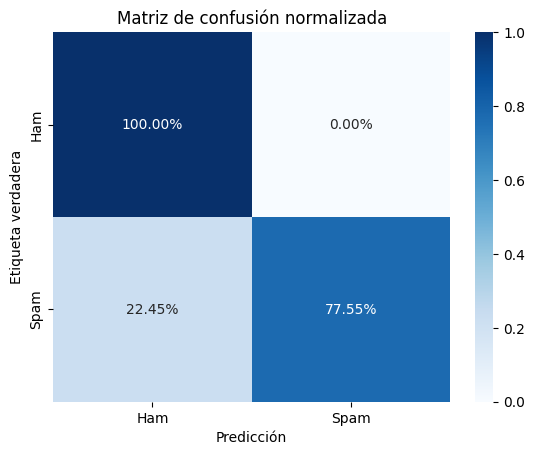

In [41]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
class_labels = ["Ham", "Spam"]
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()

# Excercise 3.3

Predict target using CountVectorizer or TfideVectorizer.

choose any classification model and justify why

In [42]:
df_comparacion = comparar_tamaños_vocabularios(tamaño_diccionarito1, 
                                               tamaño_diccionarito2)
print(df_comparacion)

+---------------+--------+
|  Diccionario  | Tamaño |
+---------------+--------+
| Diccionario 1 |  9430  |
| Diccionario 2 |  7490  |
+---------------+--------+


In [43]:
comparar_metricas(model0_metrics, 
                  model1_metrics, 
                  model2_metrics, 
                  index_name='Métrica')

Métrica,Accuracy,Recall,F1-score,auc,Phi coefficient
Modelo 1,0.874000,0.500000,0.466000,0.705000,0.000000
Modelo 2,0.966000,0.865000,0.912000,0.979000,0.838000
Modelo 3,0.972000,0.888000,0.929000,0.981000,0.867000


# Excercise 3.4

Increase and decrece the parameters values vector_size, window and negative then predict the target.

Plot the different values of the parameters with the performance of the model.

Use a Random Forest classifier and classification model of your choice and justify why.

In [54]:
from sklearn.metrics import roc_auc_score

In [73]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = df['target'], 
                                                    test_size = test_size, 
                                                    random_state = random_state)

stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train_prep = X_train.apply(preprocess)
X_test_prep = X_test.apply(preprocess)

sentences = [sentence.split() for sentence in X_train_prep]

In [74]:
def vectorize(sentence, size_vec):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(size_vec)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [65]:
# size_vec = 100

# model = Word2Vec(sentences, vector_size=size_vec, window=5, negative=20, min_count=1, workers=4)

# X_train_post = np.array([vectorize(sentence, size_vec) for sentence in X_train_prep])
# X_test_post = np.array([vectorize(sentence, size_vec) for sentence in X_test_prep])

In [66]:
# # Random Forest classifier
# # ==============================================================================
# rf_model_vz = RandomForestClassifier(random_state=random_state)
# rf_model_vz.fit(X_train_post, y_train)
# y_prob = rf_model_vz.predict_proba(X_test_post)[:, 1]
# auc = roc_auc_score(y_test, y_prob)
# auc

parameter variation: `vector_size`

In [75]:
longitud_vec = []
metric_auc = []

for i in range(50, 300, 10):

    model = Word2Vec(sentences, vector_size=i, window=5, negative=20, min_count=1, workers=4)
    X_train_post = np.array([vectorize(sentence, i) for sentence in X_train_prep])
    X_test_post = np.array([vectorize(sentence, i) for sentence in X_test_prep])

    rf_model_vz = RandomForestClassifier(random_state=random_state)
    rf_model_vz.fit(X_train_post, y_train)
    y_prob = rf_model_vz.predict_proba(X_test_post)[:, 1]
    auc = roc_auc_score(y_test, y_prob)

    longitud_vec.append(i)
    metric_auc.append(auc)

    df_aux = pd.DataFrame(list(zip(longitud_vec, metric_auc)),
                          columns =['Vector size', 'AUC'])
    df_aux = df_aux.sort_values(by=['AUC'], ascending=False)

df_aux.head()

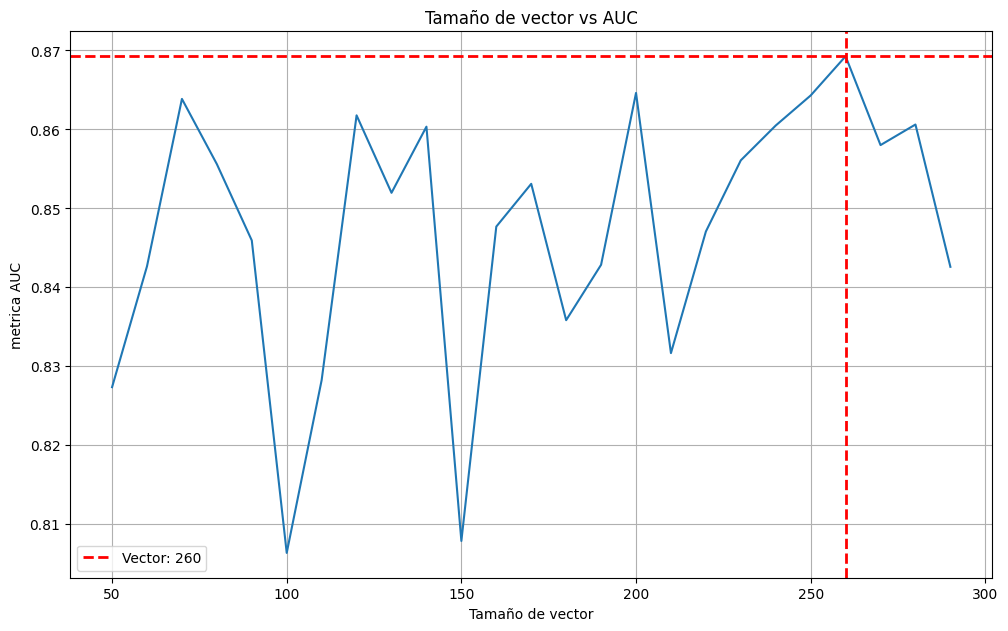

In [101]:
plt.figure(figsize=(10,6)) 
plt.plot(longitud_vec, metric_auc)
plt.axhline(y=max(metric_auc), color='red', linestyle='dashed', linewidth=2)
plt.axvline(x=longitud_vec[metric_auc.index(max(metric_auc))], color='red', linestyle='dashed', linewidth=2, label=f'Vector: {longitud_vec[metric_auc.index(max(metric_auc))]}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlabel('Tamaño de vector')
plt.ylabel('metrica AUC')
plt.title('Tamaño de vector vs AUC')
plt.show()

parameter variation: `window`

In [103]:
longitud_window = []
metric_auc = []

for i in range(1, 50, 1):

    model = Word2Vec(sentences, vector_size=100, window=i, negative=20, min_count=1, workers=4)
    X_train_post = np.array([vectorize(sentence, 100) for sentence in X_train_prep])
    X_test_post = np.array([vectorize(sentence, 100) for sentence in X_test_prep])

    rf_model_vz = RandomForestClassifier(random_state=random_state)
    rf_model_vz.fit(X_train_post, y_train)
    y_prob = rf_model_vz.predict_proba(X_test_post)[:, 1]
    auc = roc_auc_score(y_test, y_prob)

    longitud_window.append(i)
    metric_auc.append(auc)

    df_aux = pd.DataFrame(list(zip(longitud_window, metric_auc)),
                          columns =['Window size', 'AUC'])
    df_aux = df_aux.sort_values(by=['AUC'], ascending=False)

df_aux.head()

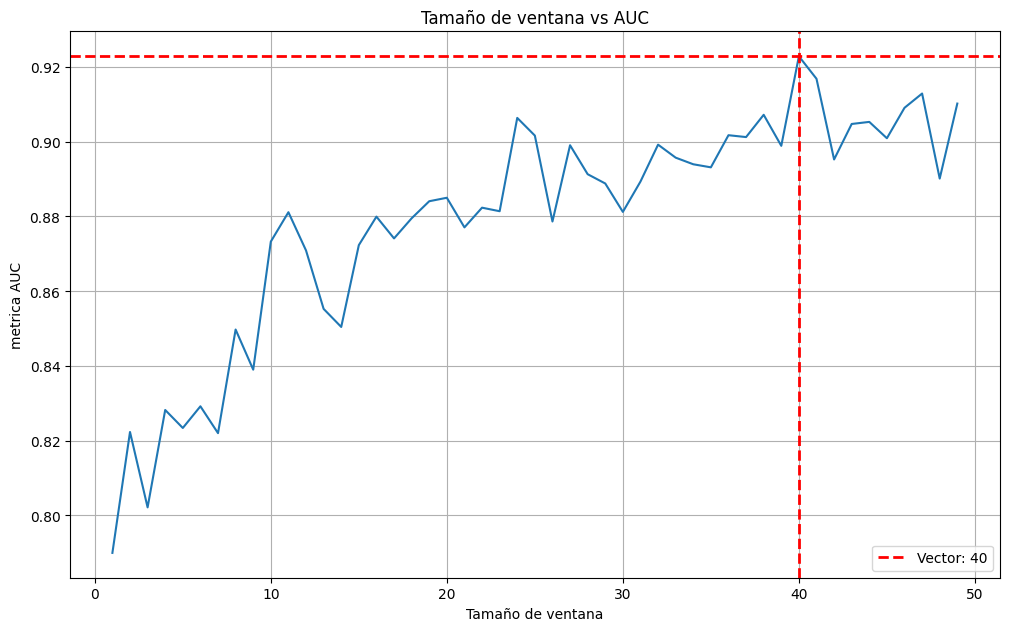

In [105]:
plt.figure(figsize=(10,6)) 
plt.plot(longitud_window, metric_auc)
plt.axhline(y=max(metric_auc), color='red', linestyle='dashed', linewidth=2)
plt.axvline(x=longitud_window[metric_auc.index(max(metric_auc))], color='red', linestyle='dashed', linewidth=2, label=f'Vector: {longitud_window[metric_auc.index(max(metric_auc))]}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlabel('Tamaño de ventana')
plt.ylabel('metrica AUC')
plt.title('Tamaño de ventana vs AUC')
plt.show()

parameter variation: `negative`

In [106]:
longitud_negative = []
metric_auc = []

for i in range(10, 50, 10):

    model = Word2Vec(sentences, vector_size=100, window=5, negative=i, min_count=1, workers=4)
    X_train_post = np.array([vectorize(sentence, 100) for sentence in X_train_prep])
    X_test_post = np.array([vectorize(sentence, 100) for sentence in X_test_prep])

    rf_model_vz = RandomForestClassifier(random_state=random_state)
    rf_model_vz.fit(X_train_post, y_train)
    y_prob = rf_model_vz.predict_proba(X_test_post)[:, 1]
    auc = roc_auc_score(y_test, y_prob)

    longitud_negative.append(i)
    metric_auc.append(auc)

    df_aux = pd.DataFrame(list(zip(longitud_negative, metric_auc)),
                          columns =['Negative size', 'AUC'])
    df_aux = df_aux.sort_values(by=['AUC'], ascending=False)

df_aux.head()

,Negative size,AUC
2,30,0.830198
1,20,0.827231
0,10,0.813591
3,40,0.795280


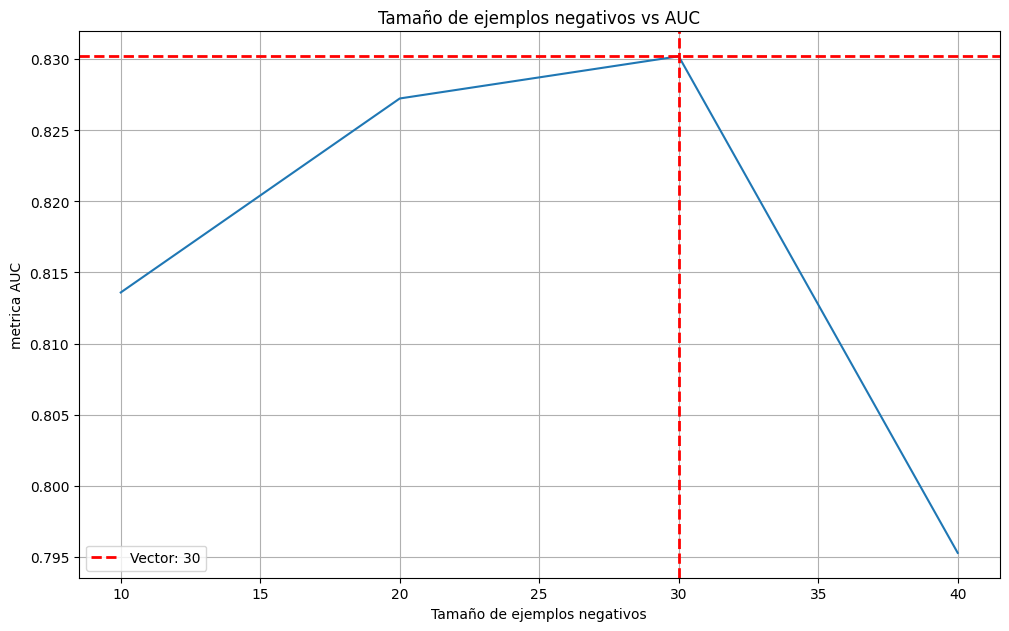

In [107]:
plt.figure(figsize=(10,6)) 
plt.plot(longitud_negative, metric_auc)
plt.axhline(y=max(metric_auc), color='red', linestyle='dashed', linewidth=2)
plt.axvline(x=longitud_negative[metric_auc.index(max(metric_auc))], color='red', linestyle='dashed', linewidth=2, label=f'Vector: {longitud_negative[metric_auc.index(max(metric_auc))]}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlabel('Tamaño de ejemplos negativos')
plt.ylabel('metrica AUC')
plt.title('Tamaño de ejemplos negativos vs AUC')
plt.show()

Running best parameters `vector_size, window and negative` (All at the same time)

In [109]:
model = Word2Vec(sentences, vector_size=260, window=40, negative=30, min_count=1, workers=4)
X_train_post = np.array([vectorize(sentence, 260) for sentence in X_train_prep])
X_test_post = np.array([vectorize(sentence, 260) for sentence in X_test_prep])

rf_model_f = RandomForestClassifier(random_state=random_state)
rf_model_f.fit(X_train_post, y_train)

RandomForestClassifier(random_state=18)

In [111]:
y_pred = rf_model_f.predict(X_test_post)
y_prob = rf_model_f.predict_proba(X_test_post)[:, 1]
modelf_metrics = print_metrics(y_test, y_pred, y_prob)


The results of the adjustment metrics:

      Accuracy: 0.933
      Recall: 0.767
      F1-score: 0.818
      auc: 0.905
      Phi coefficient: 0.660


In [112]:
comparar_metricas(model0_metrics, 
                  model1_metrics, 
                  model2_metrics, 
                  modelf_metrics,
                  index_name='Métrica')

Métrica,Accuracy,Recall,F1-score,auc,Phi coefficient
Modelo 1,0.874000,0.500000,0.466000,0.698000,0.000000
Modelo 2,0.966000,0.865000,0.912000,0.979000,0.838000
Modelo 3,0.972000,0.888000,0.929000,0.981000,0.867000
Modelo 4,0.933000,0.767000,0.818000,0.905000,0.660000


In [ ]:
print('ok_')